# Molecular Dynamics
## Initializing a system to a specific density

Sometimes as molecular simulators, we may be interested in how a material behaves at high density. However, starting our simulation with densely packed molecules will often cause errors. This tutorial will explain some of the common pitfalls of initializing a system at high density and how to overcome them by using a "shrink step."

<a id="toc"></a>
## Table of Contents
- [Attempting to start with a dense system](#init-dense)
- [Solution: Use shrink step to gradually increase density](#shrink)
- [Analysis: Do we achieve the target density?](#analysis)

In [1]:
import foyer
import gsd
import gsd.hoomd
import hoomd
import matplotlib.pyplot as plt
import mbuild as mb
from mbuild.formats.hoomd_simulation import create_hoomd_simulation
import numpy as np
import parmed as pmd

from utils.draw_scene import snap_render, display_movie

/Users/jenny/miniconda3/envs/cmelab/lib/python3.7/site-packages/hoomd/meta.py:26: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


<a id="init-dense"></a>
## Attempting to start with a dense system


[back to top](#toc)

Let's say we want to run a simulation of a system of liquid propane at high density. First, we'll generate a single propane molecule using mBuild's [SMILES](https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html) generator. (In SMILES notation capital "C" represents alkyl carbon, so three alkyl carbons is propane.) In the below visualization, carbon atoms are colored grey and hydrogens are white. 

In [2]:
propane = mb.load("CCC", smiles=True)

propane.visualize().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Let's say we want specifically a system of propane at a density of 0.6 g/mL. First we'll need to calculate how many propane molecules to put in our box.
mBuild and foyer use these [units](http://docs.openmm.org/7.2.0/userguide/theory.html#units) (nm, amu)

1 amu = 1.66054e-24 g

1 mL = 1 cm$^{3}$ = 1e21 nm$^{3}$

For simplicity, let's say that each propane molecule is 44 amu (3 carbons @12 amu + and 8 hydrogens @1 amu)

If our box volume is 2x2x2 nm (8 nm$^{3}$), then how many propane molecules do we need to fill it at this density?

In [3]:
target_density = 0.6 /1e21 / 1.66054e-24
print(f"The target density is {target_density:.2f} in amu/nm^3")

number = int(round(target_density * 8 / 44))
print(f"This means we need {number} propane molecules to fill a 2x2x2 nm box")

The target density is 361.33 in amu/nm^3
This means we need 66 propane molecules to fill a 2x2x2 nm box


We can then use mBuild's `fill_box` function (which uses [PACKMOL](http://m3g.iqm.unicamp.br/packmol/home.shtml) under the hood) to fill our box to the desired density.

In [4]:
box = mb.Box([2,2,2])
system_box = mb.packing.fill_box(propane, number, box=box)
system_box.visualize().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Next, in order to run our system, we will apply a forcefield using [foyer](https://foyer.mosdef.org/en/stable/). In this example we're using foyer's built-in [OPLSAA](https://doi.org/10.1021/ja00214a001) force field.

In [5]:
system_box_pmd = system_box.to_parmed(box=box)
oplsaa = foyer.forcefields.load_OPLSAA()
box_struc = oplsaa.apply(system_box_pmd, assert_dihedral_params=False)

/Users/jenny/miniconda3/envs/cmelab/lib/python3.7/site-packages/foyer/forcefield.py:449: UserWarning: No force field version number found in force field XML file.
  'No force field version number found in force field XML file.'
/Users/jenny/miniconda3/envs/cmelab/lib/python3.7/site-packages/foyer/forcefield.py:461: UserWarning: No force field name found in force field XML file.
  'No force field name found in force field XML file.'
/Users/jenny/miniconda3/envs/cmelab/lib/python3.7/site-packages/foyer/validator.py:132: ValidationWarning: You have empty smart definition(s)
  warn("You have empty smart definition(s)", ValidationWarning)
/Users/jenny/miniconda3/envs/cmelab/lib/python3.7/site-packages/foyer/forcefield.py:267: UserWarning: Parameters have not been assigned to all impropers. Total system impropers: 792, Parameterized impropers: 0. Note that if your system contains torsions of Ryckaert-Bellemans functional form, all of these torsions are processed as propers
  warnings.warn(ms

Now that we have our simulation volume, we can set up our MD simulation to run in [HOOMD](https://hoomd-blue.readthedocs.io/en/stable/) using mbuild's `create_hoomd_simulation` funciton. This will read in the atom positions, bonding information, and forcefield parameters that we have already set. 

In [6]:
# NBVAL_SKIP
create_hoomd_simulation(box_struc, r_cut=1.2, auto_scale=True)

HOOMD-blue 2.9.0 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 05/18/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Lui, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU


*Warning*: pos 15:-2.8694665432 -2.34268379211 -0.0676562860608
*Warning*: fractional pos :-0.00215664505959 0.09003033638 0.488160149939
*Warning*: lo: -2.85714285714 -2.85714285714 -2.85714285714
*Warning*: hi: 2.85714285714 2.85714285714 2.85714285714
*Warning*: Not all particles were found inside the given box


RuntimeError: Error initializing ParticleData

<a id="shrink"></a>
## Solution: Use shrink step to gradually increase density

<span style="color:red">Why does the cell above cause an error?</span>
HOOMD is having trouble initializing the propane system at this high density. The propane molecules haven't had any time to bend or stretch, which might be necessary to fit into the high density system. Let's instead initalize at a low density and then use the `box_resize` function to gradually shrink down to our desired density.

Now that the box is bigger, we can also use the `edge` option in the `fill_box` function to assure that all molecules are further from the box edges.


[back to top](#toc)

In [7]:
box_sparse = mb.Box([10,10,10])
system_box_sparse = mb.packing.fill_box(propane, number, box=box_sparse, edge=0.5)
system_box_sparse.visualize().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Now our starting system has lots of room to move around. Again, we'll apply our OPLSAA forcefield and initialize HOOMD with the `create_hoomd_simulation` function.

In [8]:
system_box_sparse_pmd = system_box_sparse.to_parmed(box=box_sparse)
oplsaa = foyer.forcefields.load_OPLSAA()
box_struc_sparse = oplsaa.apply(system_box_sparse_pmd, assert_dihedral_params=False)

In [9]:
create_hoomd_simulation(box_struc_sparse, r_cut=1.2, auto_scale=True)

notice(2): Group "all" created containing 726 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 4 exclusions             : 528
notice(2): Particles with 7 exclusions             : 132
notice(2): Particles with 10 exclusions             : 66
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
Processing LJ and QQ
notice(2): Group "charged" created containing 726 particles
-----
You are using PPPM. Please cite the following:
* D N LeBard, B G Levine, S A Barr, A Jusufi, S Sanders, M L Klein, and A Z
  Panagiotopoulos. "Self-assembly of coarse-grained ionic surfactants
  accelerated by graphics processing units", Journal of Computational Physics 8
  (2012) 2385-2397
-----
Processing 1-4 interactions, adjusting neighborlist exclusions
Processing harmonic bonds
Processing harmonic angles
Processing RB torsions
HOOMD SimulationContext updated from ParmEd Structure


([<hoomd._hoomd.SnapshotSystemData_float at 0x127cb38f0>,
 ref_values(distance=3.5, mass=12.01078, energy=0.066))

Below is an example of how you can edit the forces in HOOMD after initialization. The charges in the propane system shouldn't be a driving force for their self-assembly, so we can safely ignore them.

In [10]:
forces = [
    f for f in hoomd.context.current.forces 
    if not isinstance(f, hoomd.md.charge.pppm)
]
hoomd.context.current.forces = forces
hoomd.context.current.forces

Next we tell HOOMD how we want our simulation to run: how big we want our timestep (`dt`), which integrator to use (`hoomd.md.integrate.nvt`), what temperature (`kT`) to use, and how strongly to couple our system to the thermostat (`tau`). The [gsd](https://gsd.readthedocs.io/en/stable/) files will contain the simulation snapshots as the run progresses. 

We also intialize our system with random velocities (`integrator.randomize_velocities`) to help the system equilibrate without a sudden jump.

Most importantly, we use [box_resize](https://hoomd-blue.readthedocs.io/en/stable/module-hoomd-update.html?highlight=box%20resize#hoomd.update.box_resize) to shrink from our inital box (10nm) to our target box (2nm). The values given to [linear_interp](https://hoomd-blue.readthedocs.io/en/stable/module-hoomd-variant.html#hoomd.variant.linear_interp) are pairs containing (time step, set value).

<span style="color:red">IMPORTANT NOTE</span>: mBuild/foyer length units are nanometers, when the system is converted to parmed (`system_box.to_parmed`) the length units are converted to Angstroms. HOOMD is unit agnostic, but the system used to initialize the simulation is in Angstroms which is why the numbers in `box_resize` are 100 and 20 instead of 10 and 2. (100Å = 10nm)

In [11]:
_all = hoomd.group.all()
hoomd.md.integrate.mode_standard(dt=0.0001)
integrator = hoomd.md.integrate.nvt(group=_all, kT=1.0, tau=0.1)
hoomd.dump.gsd("trajectories/start-shrink.gsd", period=None, group=_all, overwrite=True)
hoomd.dump.gsd("trajectories/traj-shrink.gsd", period=1e5, group=_all, phase=0, overwrite=True)
integrator.randomize_velocities(seed=42);

hoomd.update.box_resize(L = hoomd.variant.linear_interp([(0,100), (1e6,20)], zero=0));

In [12]:
hoomd.run(1e6)
gsd_restart = hoomd.dump.gsd("trajectories/out-shrink.gsd", period=None, group=_all, overwrite=True);
gsd_restart.write_restart()

** starting run **
Time 00:00:10 | Step 17468 / 1000000 | TPS 1746.76 | ETA 00:09:22
Time 00:00:20 | Step 36639 / 1000000 | TPS 1917.1 | ETA 00:08:22
Time 00:00:30 | Step 55436 / 1000000 | TPS 1879.63 | ETA 00:08:22
Time 00:00:40 | Step 75236 / 1000000 | TPS 1979.94 | ETA 00:07:47
Time 00:00:50 | Step 94961 / 1000000 | TPS 1972.47 | ETA 00:07:38
Time 00:01:00 | Step 114251 / 1000000 | TPS 1928.93 | ETA 00:07:39
Time 00:01:10 | Step 133974 / 1000000 | TPS 1972.21 | ETA 00:07:19
Time 00:01:20 | Step 153740 / 1000000 | TPS 1976.57 | ETA 00:07:08
Time 00:01:30 | Step 172678 / 1000000 | TPS 1893.72 | ETA 00:07:16
Time 00:01:40 | Step 191665 / 1000000 | TPS 1898.65 | ETA 00:07:05
Time 00:01:50 | Step 210739 / 1000000 | TPS 1907.35 | ETA 00:06:53
Time 00:02:00 | Step 230485 / 1000000 | TPS 1974.52 | ETA 00:06:29
Time 00:02:10 | Step 250794 / 1000000 | TPS 2030.83 | ETA 00:06:08
Time 00:02:20 | Step 269507 / 1000000 | TPS 1871.28 | ETA 00:06:30
Time 00:02:30 | Step 288311 / 1000000 | TPS 1880.

<a id="analysis"></a>
## Analysis: Do we achieve the target density?

In short, yes. We can use the system specified in the `out-shrink.gsd` as [a restart file](https://hoomd-blue.readthedocs.io/en/stable/restartable-jobs.html) to initialize a new simulation at this new high density. We can confirm that the density has reached its target through visualization and direct query of the box lengths stored in the gsd file.

![](images/shrink_trajectory.gif)

The above gif is generated with the code block below which uses [fresnel](https://fresnel.readthedocs.io/en/stable/).

[back to top](#toc)

In [13]:
# NBVAL_SKIP
gsdfile = "trajectories/traj-shrink.gsd"
oplsaa_colors_cpk = {
    'opls_135': 'grey',
    'opls_136': 'grey',
    'opls_140': 'white',
}

display_movie(
    snap_render, gsdfile, color=oplsaa_colors_cpk, gif="images/shrink_trajectory.gif", height=60
)

Plotting the box length throughout the trajectory shows that it does decrease linearly as we specified.

In [14]:
gsdfile = "trajectories/traj-shrink.gsd"
shrink_box = []
with gsd.hoomd.open(name=gsdfile, mode='rb') as f:
    for snap in f[1:]:
        shrink_box.append(snap.configuration.box[0])
gsdfile = "trajectories/out-shrink.gsd"
with gsd.hoomd.open(name=gsdfile, mode='rb') as f:
    shrink_box.append(f[0].configuration.box[0])

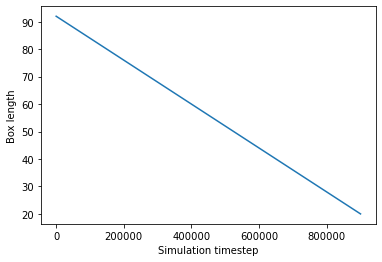

Final box length: 20.0 Angstroms


In [15]:
steps = np.array([i for i in range(len(shrink_box))])
plt.plot(steps*1e5,shrink_box)
plt.xlabel("Simulation timestep")
plt.ylabel("Box length")
plt.show()
print(f"Final box length: {shrink_box[-1]:0.1f} Angstroms")